In [1]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import copy
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime
from collections import Counter
from matplotlib.pyplot import figure

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()

#Machine learning stuff
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier   #This is a single decision tree
from sklearn.ensemble import ExtraTreesClassifier #Random forest of trees
from sklearn.linear_model import LogisticRegression #Logistic regression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, precision_score
from sklearn.model_selection import train_test_split

#Sci-bayes
from skbayes.linear_models import EBLogisticRegression,VBLogisticRegression

In [2]:
def datamap(df,params):
    #Adjust some things that are always included and may need to be used:
    
    #df['dimain'] = df.dimain.map({"Cerebral Malaria":0, "Meningoencephalitis":1, "Meningitis":2.,\
                                       #"Other":3})
    for label in params:
        #Mapping yes/no to 1/0
        if label =='date':
            df['incdate'] = pd.to_datetime(df['incdate'])
            df['date'] = (df['incdate'] - df['incdate'].min())  / np.timedelta64(1,'D')
        if label=='age':
            df['ageym'] = df.ageyrs.astype(float)*12.
            df['agemth'] = df.agemth.astype(float)
            df['age'] = df.ageym + df.agemth #total age in months
            #Mapping yes/no to 1/0
        if label=='clinjaund':
            df[label] = df.clinjaund.map({'Yes': 1, 'No': 0})
        if label=='clinhepato':
            df[label] = df.clinhepato.map({'Yes': 1, 'No': 0})
        if label=='clinspleno':
            df[label] = df.clinspleno.map({'Yes': 1, 'No': 0})
        if label=='clinconv':
            df['clinconv'] = df.clinconv.map({'Yes': 1, 'No': 0})
        if label=='clindehyd':
            df['clindehyd'] = df.clindehyd.map({'Yes': 1, 'No': 0})
        if label=='clinoedem':
            df['clinoedem'] = df.clinoedem.map({'Yes': 1, 'No': 0})
        if label=='clinlymph':
            df['clinlymph'] = df.clinlymph.map({'Yes': 1, 'No': 0})
        if label=='clinresp':
            df['clinresp'] = df.clinresp.map({'Yes': 1, 'No': 0})
        if label=='clinablung':    
            df['clinablung'] = df.clinablung.map({'Yes': 1, 'No': 0})
        if label=='clincyan':
            df['clincyan'] = df.clincyan.map({'Yes': 1, 'No': 0})
        if label=='clincapref':
            df['clincapref'] = df.clincapref.map({'Yes': 1, 'No': 0})
        if label=='clincoldext':
            df['clincoldext'] = df.clincoldext.map({'Yes': 1, 'No': 0})
        if label=='clinorcand':
            df['clinorcand'] = df.clinorcand.map({'Yes': 1, 'No': 0})
        if label=='clinhemmor':
            df['clinhemmor'] = df.clinhemmor.map({'Yes': 1, 'No': 0})
        if label=='clinaids':
            df['clinaids'] = df.clinaids.map({'Yes': 1, 'No': 0})
        if label=='vom':
            df['vom'] = df.vom.map({'Yes': 1, 'No': 0})
        if label=='diar':
            df['diar'] = df.diar.map({'Yes': 1, 'No': 0})
        if label=='headache':
            df['headache'] = df['head'] #Since 'head' is a function
            df['headache'] = df.headache.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
        if label=='conv':
            df['conv'] = df.conv.map({'Yes': 1, 'No': 0})
        if label=='age':
            df['ageym'] = df.ageyrs.astype(float)*12.
            df['agemth'] = df.agemth.astype(float)
            df['age'] = df.ageym + df.agemth #total age in months

        #Medical history variables
        if label=='mhhosp':
            df['mhhosp'] = df.mhhosp.map({'Yes': 1, 'No':0})

        #some slightly more compliated mappings
        if label=='abdpain':
            df['abdpain'] = df.abdpain.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
        if label=='muscle':
            df['muscle'] = df.muscle.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
        if label=='mhdevsp':
            df['mhdevsp'] = df.mhdevsp.map({'OTHER':1, 'GLOBAL DEVELOPMENTAL DELAY':1, 'HYDROCEPHALUS':1,
                   'HEARING LOSSES':1, 'MOTOR DEVELOPEMENTAL DELAY':1,
                   'SPEECH DEVELOPEMENTAL DELAY':1})
        #malaria rapid disagnositc
        if label=='malaria':
            df['malaria'] = df.malaria.map({'confirmed':2, 'no':0, 'probable':1})
            
        #outcome
        if label=='d3evol':
            df['d3evol'] = df.d3evol.map({'Gradual worsening':-1, 'Unchanged':0, 'Improved':1,\
                                          'Improved & worsened':-1})

        #Initial diagnosis coding: (either 'diagnosed - 0', or 'undiagnosed - 1')
        if label=='CMalaria':
            df['CMalaria'] = df.dimain.map({0:1,1:0,2:0,3:0})
        if label=='Enceph':
            df['Enceph'] = df.dimain.map({0:0,1:1,2:0,3:0})
        if label=='Mening':
            df['Mening'] = df.dimain.map({0:0,1:0,2:1,3:0})
        if label=='Other':
            df['Other'] = df.dimain.map({0:0,1:0,2:0,3:1})


        #This coding is going to be important. You'll want to figure out which categories are useful, and which
        #are practical.
        if label=='diag':
            df['diag'] = df.diag.map({'malaria':0, 'cereb malaria':0,'virus-malaria':0,\
                                                'virus-bacteria':0, 'bacteremia':0,'bact meningitis':0,\
                                                'virus-other':0,'virus':0,'malaria-bacterial':0,\
                                                'tb':0,'crypto':0, '0.0':1})

In [3]:
#Read in the datafile - don't mess with it.
data_raw = pd.read_csv("../Data/cns_data.csv")   #Using Pandas for data manipulation
data_df = data_raw.drop(['surnamenam','patinit','patientreg','mothinit'],axis=1)

#Split up 'incdate' into month, day, and year. Monthday is meant to capture seasonality.
data_df['month'] = pd.DatetimeIndex(data_df['incdate']).month
data_df['day'] = pd.DatetimeIndex(data_df['incdate']).day
data_df['year'] = pd.DatetimeIndex(data_df['incdate']).year
data_df['monthday'] = data_df['month']*30+data_df['day']

In [4]:
#The set of inputs to map:
pmap = ['glasgtot','clinjaund','clinhepato','clinspleno','clinconv','clindehyd',\
                          'clinoedem','clinlymph','clinresp','clinablung','clincyan','clincapref','clincoldext',\
                         'clinorcand','clinhemmor','clinaids',\
                         'abdpain','vom','diar','headache','muscle','conv',\
                         'age','date',\
                         'temp','card','resp','sbp','dbp','weight','height',\
                         'malaria',
                         'mhhosp',\
                'd3evol',\
               'diag']
datamap(data_df,pmap);
print np.shape(data_df)

(480, 979)


In [5]:
#Select the diagnosis data only, then go through and calculate the proportion of the previous N patients
#that ended up with each diagnosis.
diag_data = data_df.diag.values
Ntot = len(diag_data)            #Total number of patients
Ndiag = len(data_df.diag.unique())  #Total number of categories
print 'number of diagnoses:',Ndiag

#print diag_data

N = 1                            #Number of patients to use to calculate probabilities
pdiagnosis = []                  #List to keep track of diagnoses - will be (Ntot - N) x 5
count = np.zeros(Ndiag)
for i in range(Ntot-N):
    prev_pat = diag_data[i:N+i]
    for j in range(Ndiag):
        count[j] = float(Counter(prev_pat)[j])/N
    pdiagnosis.append(count.copy())
    
prediction = []
for i in range(N,Ntot):
    guess = np.random.multinomial(1,pdiagnosis[i-N])
    hold = np.where(guess==1)[0]
    prediction.append([hold[0],diag_data[i]])

#Now, add this as a feature for classification.
data_subset = data_df[N:].copy()
pdiagnosis = np.array(pdiagnosis)

data_subset['pdiag'] = pdiagnosis[:,0]
data_subset['pnone'] = pdiagnosis[:,1]

number of diagnoses: 2


In [6]:
def trainVBLR(features,data,vblr,depth=0):
    features = np.array(features)
    Npar = len(features) - 2 #dimain and diag are always included in the list, but aren't model params
    XY_df = data.loc[:,features].dropna().copy()
    print np.shape(XY_df)
    
    Input = XY_df.values
    X = Input[:,0:-2].copy()
    Y = Input[:,-1].copy()
    Y = Y.astype(float)
    
    print 'Number of patients in data set:', len(Y)
    print 'Number of features:', len(features)-2
    print 'Fitting model ...'
        
    vblr.__init__()
    vblr.fit(X,Y)    
    if depth<=1:  #If you're only fitting once
        return Input, features
        print 'model complete!'
    
    if depth>1:        #go through 'depth' number of times and drop all coefficients consistent with zero.
        depth -= 1
        covar_mat = copy.copy(vblr.sigma_)
        covar_mat = np.array(covar_mat)
        covar_mat = covar_mat.reshape([Npar+1,Npar+1])
        post_peaks = np.zeros([Npar])
        sigmas = np.zeros([Npar])
        for i in range(Npar):
            cval = vblr.coef_[0][i]
            post_peaks[i] = cval
            sigmas[i] = np.sqrt(covar_mat[i+1,i+1])

            post_peaks = np.array(post_peaks)  
            sigmas = np.array(sigmas)

            #Which are consistent (within 1 sigma) with zero?
            post_plus = post_peaks + 0.75*sigmas
            post_minus = post_peaks - 0.75*sigmas

            splus = np.sign(post_plus)
            sminus = np.sign(post_minus)

        keep = splus==sminus
        extra = [True,True]
        keep = np.concatenate([keep,extra])
        features = features[keep]
        print 'Non-zero Coefficients:',len(features)-2
        return trainVBLR(features,data,vblr,depth)
        depth = 0

                
                
                
            

In [7]:
feature_list = ['glasgtot','clinjaund','clinhepato','clinspleno','clinconv','clindehyd',\
                          'clinoedem','clinlymph','clinresp','clinablung','clincyan','clincapref','clincoldext',\
                         'clinorcand','clinhemmor','clinaids',\
                         'abdpain','vom','diar','headache','muscle','conv',\
                         'age','date',\
                         'temp','card','resp','sbp','dbp','weight','height',\
                          'mhhosp', \
                          'malaria',\
               'dimain','diag']
vblr = VBLogisticRegression()
print np.shape(data_subset)
DataTrained, feat_kept = (trainVBLR(feature_list,data_subset,vblr,depth=6))

(479, 981)
(259, 35)
Number of patients in data set: 259
Number of features: 33
Fitting model ...
nf 33 nsig 34
Non-zero Coefficients: 16
(362, 18)
Number of patients in data set: 362
Number of features: 16
Fitting model ...
nf 16 nsig 17
Non-zero Coefficients: 15
(469, 17)
Number of patients in data set: 469
Number of features: 15
Fitting model ...
nf 15 nsig 16
Non-zero Coefficients: 14
(477, 16)
Number of patients in data set: 477
Number of features: 14
Fitting model ...
nf 14 nsig 15
Non-zero Coefficients: 12
(479, 14)
Number of patients in data set: 479
Number of features: 12
Fitting model ...
nf 12 nsig 13
Non-zero Coefficients: 12
(479, 14)
Number of patients in data set: 479
Number of features: 12
Fitting model ...
nf 12 nsig 13


In [8]:
#The covariance matrix for the coefficients plus the intercept
Npar = 12
covar_mat = copy.copy(vblr.sigma_)
covar_mat = np.array(covar_mat)
covar_mat = covar_mat.reshape([Npar+1,Npar+1])

#The values of the coefficients and the intercept
post_peaks = np.zeros([Npar])
sigmas = np.zeros([Npar])
post_peaks[0] = copy.copy(vblr.intercept_[0])
sigmas[0] = np.sqrt(covar_mat[0,0])
for i in range(Npar):
    cval = vblr.coef_[0][i]
    post_peaks[i] = cval
    sigmas[i] = np.sqrt(covar_mat[i+1,i+1])
    
post_peaks = np.array(post_peaks)  #You could keep track of the intercept but why?
sigmas = np.array(sigmas)
print len(post_peaks)

12


In [9]:
print feat_kept

['clinconv' 'clinoedem' 'clinlymph' 'clinablung' 'clincapref' 'headache'
 'age' 'date' 'temp' 'weight' 'mhhosp' 'malaria' 'dimain' 'diag']


In [10]:
#Just putting together a vector to help with plotting the weights
xplot = np.linspace(0,Npar-1,Npar)

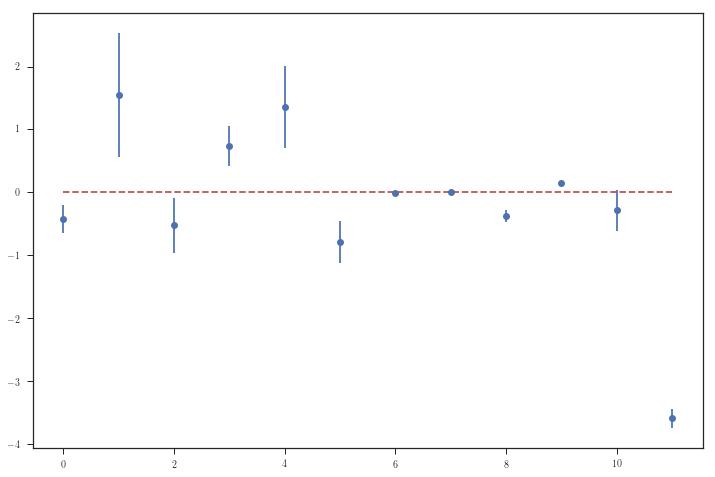

In [11]:
figure(figsize=(12,8))
plt.errorbar(xplot,post_peaks,yerr=sigmas,fmt='o')
#plt.ylim(-0.01,0.01)
#plt.xlim(20.5,32.5)
plt.plot(xplot,np.zeros(len(xplot)),'r--')
plt.savefig("BayesReg_posteriors.png")

In [12]:
#Get the Dr's Diagnoses for these same patients. Then compare this diagnosis to the classifier.
diag_MD = DataTrained[:,-2].copy()
i = 0
for d in diag_MD:
    if d == 'Other':
        diag_MD[i] = 1.
    else:
        diag_MD[i] = 0.
    i += 1

In [13]:
#4 categories: true 0, doc 0, true 0, doc 1, true 1, doc 1, true 1 doc 0
Y = DataTrained[:,-1].copy()
Npatient = len(Y)
doc_cat = np.zeros([4])

for i in range(Npatient):
    T = Y[i]
    MD = diag_MD[i]
    if T==0. and MD==0.:
        doc_cat[0] += 1
    if T==0. and MD==1.:
        doc_cat[1] += 1
    if T==1. and MD==1.:
        doc_cat[2] += 1
    if T==1. and MD==0.:
        doc_cat[3] += 1
print doc_cat

[244.  16.   4. 215.]


In [14]:
#The doctors are BAD at finding the undiagnosable patients
X = DataTrained[:,:-2].copy()
y_pred = vblr.predict(X)
print len(y_pred)

479


In [15]:
Npatient = len(Y)
reg_cat = np.zeros([4])

for i in range(Npatient):
    T = Y[i]
    MD = y_pred[i]
    #print T, MD
    if T==0. and MD==0.:
        reg_cat[0] += 1
    if T==0. and MD==1.:
        reg_cat[1] += 1
    if T==1. and MD==1.:
        reg_cat[2] += 1
    if T==1. and MD==0.:
        reg_cat[3] += 1

In [16]:
print doc_cat
print reg_cat

print 'check sum:', np.sum(doc_cat), np.sum(reg_cat)

[244.  16.   4. 215.]
[183.  77. 213.   6.]
check sum: 479.0 479.0


In [51]:
TZero = len(Y) - sum(Y)
TOne = sum(Y)

N = 3
ind = np.arange(N)
ZeroZero = np.array([reg_cat[0],doc_cat[0],TZero]) #Goes in order of MD, classifier, truth
ZeroOne = np.array([reg_cat[1],doc_cat[1],0.])
OneOne = np.array([reg_cat[2],doc_cat[2],TOne])
OneZero = np.array([reg_cat[3],doc_cat[3],0.])
width = 0.5

print ZeroZero+OneOne
#Splitting stuff up for plots for talk
ZeroZero = ZeroZero[:]
ZeroOne = ZeroOne[:]
OneOne = OneOne[:]
OneZero = OneZero[:]

print np.shape(ZeroZero), np.shape(ZeroOne), np.shape(OneOne), np.shape(OneZero)

[396. 248. 479.]
(3,) (3,) (3,) (3,)


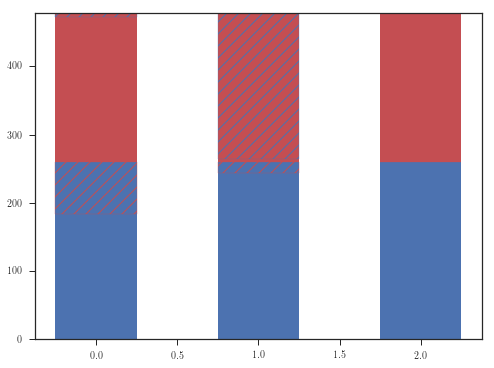

In [18]:
figure(figsize=(8,6))
p1 = plt.bar(ind,ZeroZero,width,color='b')
p2 = plt.bar(ind,ZeroOne,width,bottom=ZeroZero,color='b',edgecolor='r',hatch='//')
p3 = plt.bar(ind,OneOne,width,bottom=(ZeroOne+ZeroZero),color='r')
p4 = plt.bar(ind,OneZero,width,bottom=OneOne+ZeroOne+ZeroZero,color='r',edgecolor='b',hatch='//')

plt.savefig('allmodelsinitial_diag.png',dpi=400)

In [19]:
#clinical signs at 3 days - do the patients that are diagnosable have better outcomes than the 'Other' category? (d3evol)
#discharge and treatments received: did they get antibiotics, antivirals, antimalarials?
#did the treatments have any correlation with the outcome? In diagnosed/un-diagnosed kids
#csf - lumbar puncture
#bf - before admission
#at - at admission
#after tt, there are a bunch of drugs listed. tt is the drugs they received during treatment.
#atb: antibacterials
#atv: antiviral. etc.
#ttatb: antibiotic (in hospital, after lumbar puncture)
#ttvir: antivirals
#ttmal: antimalarials
#data_raw.d3evol: outcome

In [20]:
#First of all, is there a difference in outcome between diagnosed/undiagnosed?


In [21]:
Diagnosis = data_df.diag.values.copy()
Outcome = data_df.d3evol.values.copy()

Cats = np.zeros(4)  #no diag - improved, no diag - worsen, diag - improved, diag - worsen
for i in range(len(Diagnosis)):
    D = Diagnosis[i]
    O = Outcome[i]
    if D==1:
        if O==1. or O==0.:
            Cats[0] += 1.
        if O==-1.:
            Cats[1] += 1.
    if D==0:
        if O==1. or O==0.:
            Cats[2] += 1.
        if O==-1.:
            Cats[3] += 1.
CatsNormed = Cats.copy()
CatsNormed[0] /= Cats[0]+Cats[1]
CatsNormed[1] /= Cats[0]+Cats[1]
CatsNormed[2] /= Cats[2]+Cats[3]
CatsNormed[3] /= Cats[2]+Cats[3]

<BarContainer object of 4 artists>

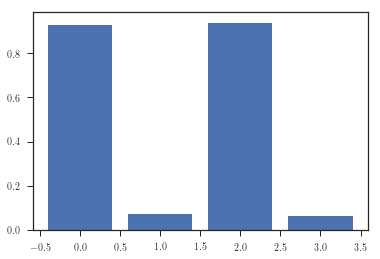

In [22]:
plt.bar([0,1,2,3],CatsNormed)

In [23]:
#Does the computer predict the *treatment* well? (antibac, antimal, both, none)
#Can the computer predict, given the doctor's diagnosis vs. the computer's diagnosis, the outcome?

#Clinical signs + treatment -> predict clinical signs at d3evol? (first you can just look at 'improving vs. not 
#improving' in re: the categories above)

In [24]:
#Now you want to make the bar chart showing initial treatment and final treatment, and the initially missed treatments.
#These numbers all exist already in your notebook - in that grid. 
#Now the categories are 'need atm,' 'need atb,' and 'need both' (replace with 'got')
#Needed antibiotics: 51
#Needed antimalarials: 20
#Needed both: 109 

TrueTreat = [51,20,109,0]   #atb,atm,both,none (180 total patients)
IntakeTreat = [28,31,58,63]
MLTreat = [51,32,97,0]


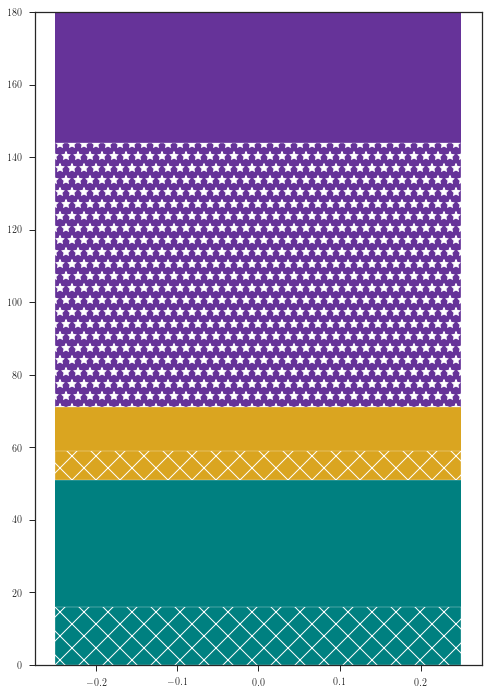

In [49]:
figure(figsize=(8,12))
#Actual treatment needed
p1 = plt.bar(0,TrueTreat[0],width,color='teal')
p2 = plt.bar(0,TrueTreat[1],width,bottom=TrueTreat[0],color='goldenrod')
p3 = plt.bar(0,TrueTreat[2],width,bottom=TrueTreat[0]+TrueTreat[1],color='rebeccapurple')
p4 = plt.bar(0,TrueTreat[3],width,bottom=TrueTreat[0]+TrueTreat[1]+TrueTreat[2],color='firebrick')

#Who got 'none'?
#p = plt.bar(0,28,width,color='teal',edgecolor='white',hatch='x') #need atb
#p = plt.bar(0,9,width,color='goldenrod',bottom = TrueTreat[0],edgecolor='white',hatch='x') #need atm
#p = plt.bar(0,26,width,color='rebeccapurple',bottom=TrueTreat[0]+TrueTreat[1],edgecolor='white',hatch='x') #need both

#Who got antimalarials?
#p = plt.bar(0,20,width,color='rebeccapurple',edgecolor='white',hatch='x',\
 #           bottom=TrueTreat[0]+TrueTreat[1]) #need both
#p = plt.bar(0,0,width,color='teal',edgecolor='white',hatch='x') #need atb
#p = plt.bar(0,12,width,color='goldenrod',edgecolor='white',hatch='*',bottom=51) #need atm

#Who got antibiotics?
#p = plt.bar(0,0,width,color='goldenrod',edgecolor='white',hatch='x',bottom=51) #need atm
#p = plt.bar(0,16,width,color='rebeccapurple',edgecolor='white',hatch='x',
#            bottom=TrueTreat[0]+TrueTreat[1]) #need both
#p = plt.bar(0,35,width,color='teal',edgecolor='white',hatch='*') #need atb

#Who got both?
p = plt.bar(0,16,width,color='teal',edgecolor='white',hatch='x') #need atb
p = plt.bar(0,8,width,color='goldenrod',edgecolor='white',hatch='x',bottom=51) #need atm
p = plt.bar(0,73,width,color='rebeccapurple',edgecolor='white',hatch='*',bottom=71) #need both

plt.savefig('classifier_both.png')

#Grid Values (intake treatment)
#       atb atm both none
# atb   21. 1.  1.   28.
# atm   0.  11. 0.   9.
# both  7.  19. 57.  26. 
# none  0.  0.  0.   0.

#Machine classifier
#       atb atm both none
# atb   35. 0.  16.  0.
# atm   0.  12. 8.   0.
# both  16. 20. 73.  0.
# none  0.  0.  0.   0.